# Наумкин Владимир, С01-119.
# Домашнее задание 2.

## Подключим библиотеки

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

## Загрузка и анализ тренировочной выборки

In [2]:
sample = pd.read_csv('train.csv')
sample.head()

,index,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18
0,0,495.67,17.0,1,22,0,1,0.0,0.0,185.18,287.05,0.85,6.33,54.38,0.0,0.0,0.00,30.54,0.0,509.94
1,1,595.67,21.0,1,32,0,1,0.0,0.0,76.28,522.28,0.00,7.96,190.97,0.0,0.0,0.00,0.00,0.0,606.52
2,2,786.37,10.0,1,45,1,2,0.0,0.0,131.27,566.15,0.00,20.23,328.13,0.0,0.0,8.85,0.00,0.0,726.50
3,3,1142.63,10.0,1,41,0,2,0.0,0.0,307.49,926.55,0.00,8.08,351.38,0.0,0.0,0.00,5.05,0.0,1247.17
4,4,567.47,19.0,1,36,0,1,0.0,0.0,4.18,529.77,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,533.95


Как и было обещано, у нас 18 признаков, не считая целевого. Посмотрим на распределение целевого признака, для которого нам надо решить задачу регресии.

<Axes: xlabel='y', ylabel='Density'>

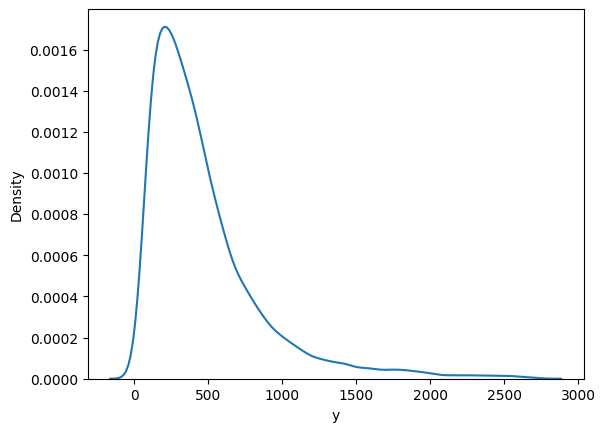

In [3]:
sns.kdeplot(sample.y)

Можно также вычислить его среднее. Максимум распределения приходится не на него, т.к. есть достаточно много объектов с большим целевым значением, что сильно влияет на среднее значение.

In [4]:
sample.y.mean()

np.float64(471.28077)

Отделим целевую переменную, а также возьмём 20% тренировочной выборки для проверки модели.

In [5]:
X = sample.drop(columns=['y'])
y = sample['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

## Используем линейную регрессию

In [6]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression().fit(X_train, y_train)

Проверим значение метрики MAPE на отложенных для проверки данных.

In [7]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred = lin_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.35180995547420596


## Попробуем использовать именно метрику MAPE для обучения модели

In [8]:
from scipy.optimize import minimize

def mape_loss(params, X, y):
    intercept = params[0]
    coefficients = params[1:]
    y_pred = X.dot(coefficients) + intercept
    return np.mean(np.abs((y - y_pred) / y))

initial_params = np.zeros(X_train.shape[1] + 1)
result = minimize(mape_loss, initial_params, args=(X_train, y_train))
optimal_params = result.x

mape_model = LinearRegression()
mape_model.coef_ = optimal_params[1:]
mape_model.intercept_ = optimal_params[0]

Посмотрим, улучшилось ли предсказание.

In [12]:
y_pred = mape_model.predict(X_test.values)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.24316555833242298


### Результат однозначно лучше, поэтому попробуем вернуть 20% тренировочной выборки, ещё раз обучить модель и проверить её на тестовой выборке (получить предсказание и отправить на kaggle).

In [24]:
initial_params = np.zeros(X.shape[1] + 1)
result = minimize(mape_loss, initial_params, args=(X, y))
optimal_params = result.x

mape_model = LinearRegression()
mape_model.coef_ = optimal_params[1:]
mape_model.intercept_ = optimal_params[0]

Для успокоения сначала проверим предсказание всех данных, уже и так использованных для обучения.

In [25]:
y_pred = mape_model.predict(X.values)
mape = mean_absolute_percentage_error(y, y_pred)
print(mape)

0.24212251473274665


Точность совсем чуть-чуть увеличилась, видимо это предел модели при таком решении "в лоб".

Теперь загружаем тестовую выборку, получаем предсказание, сохраняем и отправляем его на kaggle.

In [26]:
test = pd.read_csv('test.csv')
test.head()

,index,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18
0,0,14.0,1,30,1,1,0.00,0.0,209.29,358.34,0.0,1.49,33.67,0.0,0.0,0.00,1.60,0.00,570.72
1,1,14.0,0,26,0,1,154.91,0.0,19.08,146.38,0.0,0.00,96.97,0.0,0.0,0.00,0.00,0.00,165.45
2,2,10.0,1,32,0,1,0.00,0.0,121.21,428.18,0.0,17.90,62.89,0.0,0.0,18.12,0.00,0.00,585.42
3,3,15.0,1,42,1,1,1244.46,0.0,407.67,804.93,0.0,9.98,932.81,0.0,0.0,20.65,2.73,2.28,1250.52
4,4,19.0,1,33,0,2,1284.48,0.0,196.50,874.94,0.0,9.17,828.86,0.0,0.0,0.00,0.21,0.37,1081.56


In [28]:
res = pd.DataFrame({'index': test.index, 'y': mape_model.predict(test.values)}).set_index('index')
res.head()

,y
index,
0,618.322825
1,180.345062
2,622.410491
3,1277.544145
4,1101.857499


In [29]:
res.to_csv('result_1.csv')